In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmos
h = cosmos.H0.value/100
from astropy.io import fits
import healpy as hp
import seaborn as sns
from scipy.optimize import minimize
from iminuit import Minuit

In [2]:
# data = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSS_WISE_imageprop_nside512.fits')
data = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSSimageprop_Nside512.fits')

In [3]:
random_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
random_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-SGC-vDR16.fits')
random_all = np.hstack((random_n, random_s))

In [4]:
quasar_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
quasar_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
quasar_all = np.hstack((quasar_n, quasar_s))

In [5]:
Nside = 512
Npix = hp.nside2npix(Nside)
print(f'scale: {hp.nside2resol(Nside, True)} arcmin')

scale: 6.870972823634812 arcmin


In [6]:
quasar_cata = quasar_n
random_cata = random_n

In [7]:
pix = hp.ang2pix(Nside, np.deg2rad(90 - quasar_cata['dec']), np.deg2rad(quasar_cata['ra']))

pix_r = hp.ang2pix(Nside, np.deg2rad(90 - random_cata['DEC']), np.deg2rad(random_cata['RA']))
pix_ur = np.unique(pix_r)

In [8]:
count = np.bincount(pix, minlength=Npix, weights=quasar_cata['WEIGHT_FKP']*quasar_cata['WEIGHT_CP']*quasar_cata['WEIGHT_NOZ'])                                            # number count in each area

Nbins = 10
bin_edge = np.linspace(0, 0.15, Nbins+1, True)
bin_center = (bin_edge[1:] + bin_edge[:-1])/2

In [9]:
Rg = 3.793                                      # from 2002AJ....123..485S table 22
ebv_q = data['EBV'][pix]
depth_g_q = 22.5 - 2.5*np.log10(data['DEPTH_G'][pix]) - Rg*ebv_q
sky_i_q = data['SKY_I'][pix]
psf_i_q = data['PSF_I'][pix]

In [10]:
# random pixels
count_all = count[pix_ur]
Ebv = data['EBV'][pix_ur]
depth_g = data['DEPTH_G'][pix_ur]
sky_i = data['SKY_I'][pix_ur]
psf_i = data['PSF_I'][pix_ur]

properties = {
    'EBV': Ebv,
    'DEPTH_G': 22.5 - 2.5*np.log10(depth_g) - Ebv*Rg,
    'SKY_I': sky_i,
    'PSF_I': psf_i
}

valid = np.ones(len(count_all), bool)
for p in properties.values():
    valid &= ~np.isnan(p)

In [11]:
# cut outliers
outliers = np.zeros(len(count_all), bool)
for feature in properties.values():
    _min, _max = np.percentile(feature[valid], [0.5, 99.5])
    outliers |= ((feature < _min) | (feature > _max))

valid &= ~outliers

count_all = count_all[valid]
for k, v in properties.items():
    properties[k] = v[valid]

density = count_all / count_all.mean()

In [14]:
y = {}
y_err = {}
x = {}
edge = {}
for name, feature in properties.items():
    Nbins = 10
    bin_edge = np.linspace(feature.min(), feature.max(), Nbins+1, True)
    bin_center = (bin_edge[1:] + bin_edge[:-1])/2
    dig_res = np.digitize(feature, bin_edge)
    res = []
    err = []
    for i in range(1, Nbins+1):
        sub_sample = density[dig_res == i]
        mean = sub_sample.mean()
        N = len(sub_sample)
        res.append(mean)
        err.append(np.sqrt(mean / N))
    y[name] = np.array(res)
    y_err[name] = np.array(err)
    x[name] = np.array(bin_center)
    edge[name] = bin_edge

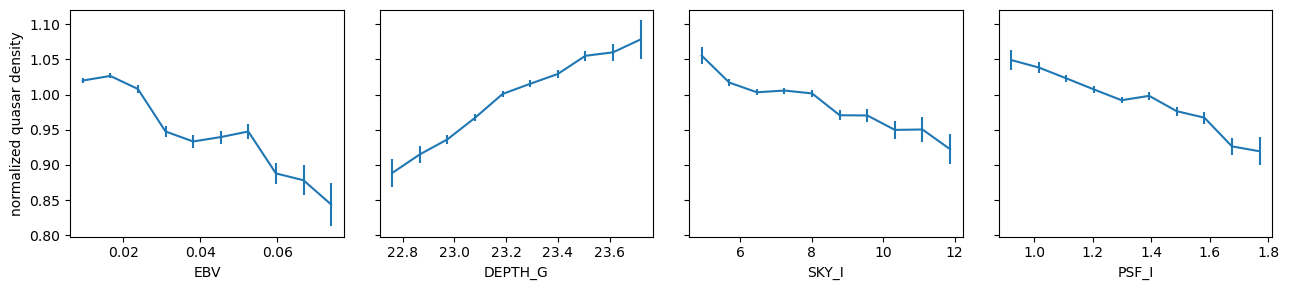

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(13, 3), sharey=True)
axes[0].set_ylabel('normalized quasar density')
for i, name in enumerate(properties.keys()):
    axes[i].errorbar(x[name], y[name], y_err[name])
    axes[i].set_xlabel(name)
plt.tight_layout()

Try to fit the curve directly

In [19]:
def chi_2(par):
    ret = 0
    for k in properties.keys():
        predict = par[k] * (x[k]-edge[k][0]) / (edge[k][-1] - edge[k][0]) + par['const']
        for k2 in properties.keys():
            if k == k2: continue
            predict += par[k2] / 2
        ret += (((predict - y[k])/y_err[k])**2).sum()
    return ret

def chi_2_warp(par):
    par_dict = dict(zip([
        'const',
        'EBV',
        'DEPTH_G',
        'SKY_I',
        'PSF_I'
    ], par))
    return chi_2(par_dict)

def chi_2_pos(*args):
    return chi_2_warp(args)

In [20]:
opt = Minuit(chi_2_pos, name=['const', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I'], const=1, EBV=-0.5, DEPTH_G=0.6, SKY_I=-0.2, PSF_I=-0.2)

In [21]:
opt.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 269.5                      │              Nfcn = 116              │
│ EDM = 7.44e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ const   │   1.039   │   0.010   │            │            │         │         │       │
│ 1 │ EBV     │  -0.090   │   0.007   │            │            │         │         │       │
│ 2 │ DEPTH_G │   0.215   │   0.012   │            │            │         │         │       │
│ 3 │ SKY_I   │  -0.096   │   0.010   │            │            │         │         │       │
│ 4 │ PSF_I   │  -0.129   │   0.011   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬──────────────────────────────────────────────┐
│         │    const      EBV  DEPTH_G    SKY_I    PSF_I │
├─────────┼──────────────────────────────────────────────┤
│   const │ 0.000104 -0.03e-3 -0.07e-3 -0.05e-3 -0.06e-3 │
│     EBV │ -0.03e-3 4.96e-05        0  0.01e-3  0.01e-3 │
│ DEPTH_G │ -0.07e-3        0 0.000139        0        0 │
│   SKY_I │ -0.05e-3  0.01e-3        0 9.86e-05  0.01e-3 │
│   PSF_I │ -0.06e-3  0.01e-3        0  0.01e-3 0.000114 │
└─────────┴──────────────────────────────────────────────┘

In [16]:
res = minimize(chi_2_warp, x0=[1, -0.5, 0.6, -0.2, -0.2], method='trust-constr')

In [22]:
par = dict(zip([
        'const',
        'EBV',
        'DEPTH_G',
        'SKY_I',
        'PSF_I'
    ], opt.values))
predict = {}
for k in properties.keys():
    pred = par[k] * (x[k]-edge[k][0]) / (edge[k][-1] - edge[k][0]) + par['const']
    for k2 in properties.keys():
        if k == k2: continue
        pred += par[k2] / 2
    predict[k] = pred

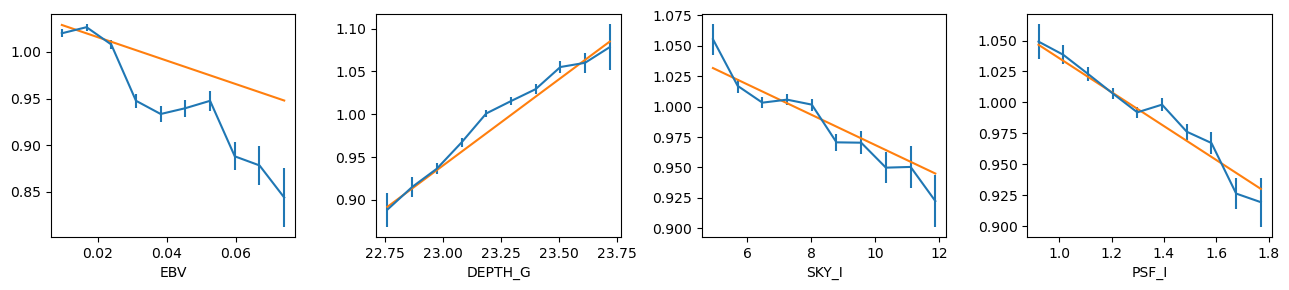

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
for i, name in enumerate(properties.keys()):
    ax[i].errorbar(x[name], y[name], y_err[name])
    ax[i].plot(x[name], predict[name])
    ax[i].set_xlabel(name)
plt.tight_layout()

try to apply weighting and then fit

In [25]:
# wd = (quasar_cata['WEIGHT_FKP']*quasar_cata['WEIGHT_CP']*quasar_cata['WEIGHT_NOZ'])
wd = quasar_cata['WEIGHT_FKP']
property_q = {}

valid_q = np.ones(len(quasar_cata), bool)
for k in properties.keys():
    valid_q &= ~np.isnan(data[k][pix])

for k in properties.keys():
    property_q[k] = data[k][pix[valid_q]]

property_q['DEPTH_G'] = 22.5 - 2.5*np.log10(property_q['DEPTH_G']) - property_q['EBV']*Rg
wd = wd[valid_q]
pix_v = pix[valid_q]

In [32]:
digitize_dict = {}
for name, feature in properties.items():
    Nbins = 10
    bin_edge = np.linspace(feature.min(), feature.max(), Nbins+1, True)
    digitize_dict[name] = np.digitize(feature, bin_edge)

def chi_2(par):
    predict = par['const']
    for k in properties.keys():
        predict += par[k] * (property_q[k]-edge[k][0]) / (edge[k][-1] - edge[k][0])
    weight = 1/(predict + 1)                                            # weight for each quasar
    if np.any(weight < 0):
        return np.inf
    count = np.bincount(pix_v, minlength=Npix, weights=wd*weight)       # degeneracy here, so we can consider setting the const to 0. 
    count = count[pix_ur][valid]
    density_w = count/count.mean()
    y_w = {}
    y_w_err = {}
    for name, feature in properties.items():
        dig_res = digitize_dict[name]
        res = []
        err = []
        for i in range(1, Nbins+1):
            sub_sample = density_w[dig_res == i]
            mean = sub_sample.mean()
            N = len(sub_sample)
            res.append(mean)
            err.append(np.sqrt(mean/N))
        y_w[name] = np.array(res)
        y_w_err[name] = np.array(err)
    # chi^2
    ret = 0.
    for k in properties.keys():
        ret += (((y_w[k] - 1) / y_w_err[k])**2).sum()
    return ret

def chi_2_warp(par):
    par_dict = dict(zip([
        'const',
        'EBV',
        'DEPTH_G',
        'SKY_I',
        'PSF_I'
    ], par))
    return chi_2(par_dict)

def chi_2_pos(*args):
    return chi_2_warp(args)

In [45]:
opt = Minuit(chi_2_pos, name=['const', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I'], const=0, EBV=-0.1, DEPTH_G=0.1, SKY_I=-0.05, PSF_I=-0.1)
opt.fixed['const'] = True
opt.limits['EBV'] = [-1, 0]
opt.limits['DEPTH_G'] = [0, 1]
opt.limits['SKY_I'] = [-1, 0]
opt.limits['PSF_I'] = [-1, 0]

In [46]:
opt.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 82.82                      │              Nfcn = 125              │
│ EDM = 6.42e-05 (Goal: 0.0002)    │            time = 3.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ const   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 1 │ EBV     │  -0.176   │   0.015   │            │            │   -1    │    0    │       │
│ 2 │ DEPTH_G │   0.052   │   0.032   │            │            │    0    │    1    │       │
│ 3 │ SKY_I   │  -0.046   │   0.012   │            │            │   -1    │    0    │       │
│ 4 │ PSF_I   │  -0.099   │   0.021   │            │            │   -1    │    0    │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬──────────────────────────────────────────────┐
│         │    const      EBV  DEPTH_G    SKY_I    PSF_I │
├─────────┼──────────────────────────────────────────────┤
│   const │        0        0    0.000        0        0 │
│     EBV │        0 0.000221  0.36e-3 -0.01e-3  0.22e-3 │
│ DEPTH_G │    0.000  0.36e-3  0.00102  0.11e-3   0.6e-3 │
│   SKY_I │        0 -0.01e-3  0.11e-3 0.000145  0.05e-3 │
│   PSF_I │        0  0.22e-3   0.6e-3  0.05e-3 0.000452 │
└─────────┴──────────────────────────────────────────────┘

In [47]:
par = dict(zip([
        'const',
        'EBV',
        'DEPTH_G',
        'SKY_I',
        'PSF_I'
    ], opt.values))
predict = par['const']
for k in properties.keys():
    predict += par[k] * (property_q[k]-edge[k][0]) / (edge[k][-1] - edge[k][0])
weight = 1/(predict + 1)

In [50]:
weight_std = quasar_n['WEIGHT_SYSTOT'][valid_q]
weight_std = weight_std / weight_std.mean()
weight = weight / weight.mean()

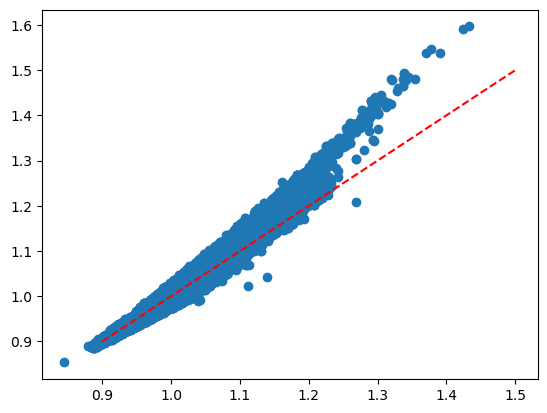

In [52]:
plt.scatter(weight_std, weight)
plt.plot([0.9, 1.5], [0.9, 1.5], 'r--')

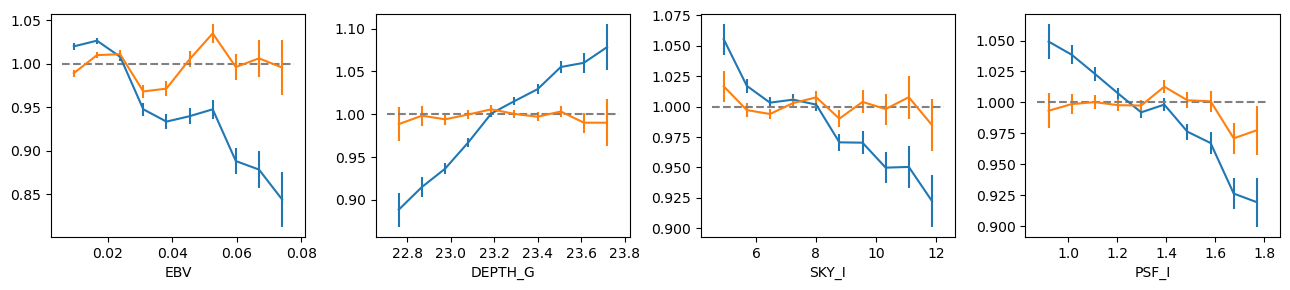

In [61]:
predict = par['const']
for k in properties.keys():
    predict += par[k] * (property_q[k]-edge[k][0]) / (edge[k][-1] - edge[k][0])
weight = 1/(predict + 1)                                            # weight for each quasar

count = np.bincount(pix_v, minlength=Npix, weights=wd*weight)
count = count[pix_ur][valid]
density_w = count/count.mean()
y_w = {}
y_w_err = {}
for name, feature in properties.items():
    dig_res = digitize_dict[name]
    res = []
    err = []
    for i in range(1, Nbins+1):
        sub_sample = density_w[dig_res == i]
        mean = sub_sample.mean()
        N = len(sub_sample)
        res.append(mean)
        err.append(np.sqrt(mean/N))
    y_w[name] = np.array(res)
    y_w_err[name] = np.array(err)
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
for i, name in enumerate(properties.keys()):
    ax[i].errorbar(x[name], y[name], y_err[name])
    ax[i].errorbar(x[name], y_w[name], y_err[name])
    ax[i].hlines(1, edge[name][0], edge[name][-1], linestyle='--', color='gray')
    ax[i].set_xlabel(name)
plt.tight_layout()

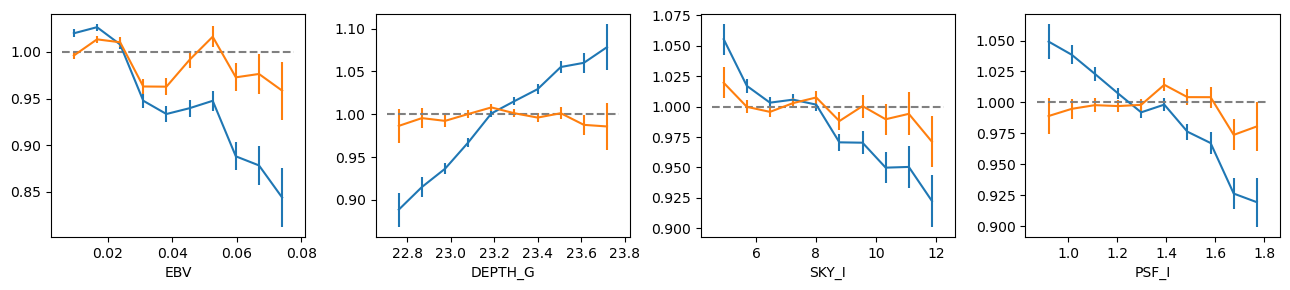

In [60]:
count = np.bincount(pix_v, minlength=Npix, weights=weight_std)
count = count[pix_ur][valid]
density_w = count/count.mean()
y_w = {}
y_w_err = {}
for name, feature in properties.items():
    dig_res = digitize_dict[name]
    res = []
    err = []
    for i in range(1, Nbins+1):
        sub_sample = density_w[dig_res == i]
        mean = sub_sample.mean()
        N = len(sub_sample)
        res.append(mean)
        err.append(np.sqrt(mean/N))
    y_w[name] = np.array(res)
    y_w_err[name] = np.array(err)
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
for i, name in enumerate(properties.keys()):
    ax[i].errorbar(x[name], y[name], y_err[name])
    ax[i].errorbar(x[name], y_w[name], y_err[name])
    ax[i].set_xlabel(name)
    ax[i].hlines(1, edge[name][0], edge[name][-1], linestyle='--', color='gray')
plt.tight_layout()